In [1]:
import jijmodeling as jm
import jijmodeling_transpiler.core as jmc
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from jijmodeling_transpiler_quantum.qiskit.minimal_encoding.to_minimal_encoding import transpiler_to_minimal_encoding

In [2]:
def knapsack():
    # define variables
    v = jm.Placeholder('v', ndim=1)
    N = v.shape[0]
    w = jm.Placeholder('w', ndim=1)
    W = jm.Placeholder('W')
    x = jm.BinaryVar('x', shape=(N,))
    i = jm.Element('i', belong_to = (0, N))
    # set problem
    problem = jm.Problem('Knapsack')
    # set objective function
    obj = - jm.sum(i, v[i]*x[i])
    problem += obj
    # set total weight constarint 
    const = jm.sum(i, w[i]*x[i])
    problem += jm.Constraint('weight', const<=W)
    return problem

In [3]:
#create a list for price (v) and weight (w)
price = [5000, 7000, 2000, 1000, 4000, 3000]
weight = [800, 1000, 600, 400, 500, 300]
#set the capacity (constrain)
capacity = 2000

data = {'v': price, 'w':weight, 'W':capacity}

problem = knapsack()

In [4]:
compiled_instance = jmc.compile_model(problem, data, {})

In [5]:
minimal_encoding_builder = transpiler_to_minimal_encoding(compiled_instance)

In [6]:
minimal_encoded_instance = minimal_encoding_builder.get_encoded_instance(multipliers = {'weight': 1.0})

In [7]:
from qiskit import QuantumRegister, AncillaRegister , QuantumCircuit
from qiskit.circuit import  ParameterVector
import qiskit as qk

def generate_circuit(num_register_bits:int, reps:int)->qk.circuit.quantumcircuit.QuantumCircuit:
    """
    Function to generate qunatum circuit (variational ansatz) for minimal encoding.

    Parameters
    ----------
    nr : int 
        number of register qubits
    reps : int
        number of layer, for this specific circuit one layer consists of C-NOT and Ry rotation gate

    Returns
    -------
    circuit : qiskit.circuit.quantumcircuit.QuantumCircuit
        Parameterised quantum circuit
    """
    #define number of qubits
    num_qubits = num_register_bits + 1
    qreg_q = QuantumRegister(num_register_bits, 'q')
    areg_a = AncillaRegister(1, 'a')
    circuit = QuantumCircuit(areg_a, qreg_q)
    
    #initialize a parameters
    parameters = ParameterVector('θ', num_qubits*reps)
    #create a dictionary of parameters with random values and return it
    initial_params =  {parameter: np.random.random() for parameter in parameters}

    #add H gate for each qubit
    circuit.h(areg_a[0])
    for i in range(0,num_register_bits):
        circuit.h(qreg_q[i])
    circuit.barrier()
  
    #add layers which consist of CNOT and Ry gate
    for j in range(0,reps):
        #CNOT
        # circuit.cx(qreg_q[0],areg_a[0])
        circuit.cx(areg_a[0],qreg_q[0])
        for i in range(num_register_bits):
            if i != 0:
                # circuit.cx(qreg_q[i],qreg_q[i-1]) 
                circuit.cx(qreg_q[i-1],qreg_q[i]) 

        #Ry
        for i in range(num_qubits):
            if i == 0:
                circuit.ry(parameters[num_qubits*j+i], areg_a[i])
            else:
                circuit.ry(parameters[num_qubits*j+i], qreg_q[i-1])  
        circuit.barrier()
    return circuit,initial_params

In [8]:
ansatz,theta = generate_circuit(minimal_encoded_instance.num_register_bits,reps=2)

In [9]:
optimized_func = minimal_encoded_instance.get_minimized_function(ansatz)

In [10]:
history = []
result = minimize(optimized_func, list(theta.values()),callback=lambda x:history.append(optimized_func(x)),method = 'BFGS')

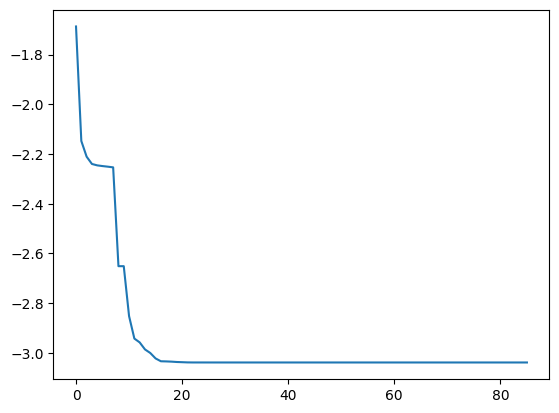

In [11]:
plt.plot(history)

In [12]:
sample_set = minimal_encoded_instance.get_optimized_state(ansatz,result.x)
sample_set

SampleSet(record=Record(solution={'x': [(([1, 5],), [1.0, 1.0], (6,))]}, num_occurrences=[1]), evaluation=Evaluation(energy=[], objective=[-10000.0], constraint_violations={"weight": [0.0]}, constraint_forall={}, constraint_values=[], penalty={}), measuring_time=MeasuringTime(solve=SolvingTime(preprocess=None, solve=None, postprocess=None), system=SystemTime(post_problem_and_instance_data=None, request_queue=None, fetch_problem_and_instance_data=None, fetch_result=None, deserialize_solution=None), total=None), metadata={})